# Kalman Filter Example 1 (Tracking an airplane)
This notebook implements the Kalman filter programmatically from the [Kalman filter lectures from iLectureOnline](https://www.youtube.com/watch?v=Fuy73n6_bBc&list=PLX2gX-ftPVXU3oUFNATxGXY90AULiqnWT&index=28&ab_channel=MichelvanBiezen) videos 26 through 42.

In [104]:
import time
import numpy as np
import matplotlib.pylab as plt
from IPython import display
%matplotlib inline

# Prediction Step (1D)

## State Update

$$ X_k = A \cdot X_{k-1} + B \cdot u_{k} + w_k $$

$$
Example: 
X_k = 
\begin{bmatrix}
1 & \Delta T\\
0 & 1 
\end{bmatrix}

\cdot 

\begin{bmatrix}
x_{k-1} \\
\dot{x}_{k-1} 
\end{bmatrix}

+

\begin{bmatrix}
\dfrac{1}{2} \Delta T^2 \\
\Delta T
\end{bmatrix}

\cdot 

a_x 

+

0

$$

- $X$: State Matrix
- $A$: State Transition Model
- $B$: Transforms controls into state
- $w_k$: Predicted state noise covariance matrix
- $u_k$: Control Variable Matrix

$$ P_k = A \cdot P_{k-1} \cdot A^T + Q $$

- $P$: State Covariance Matrix (Error in the estimate)
- $Q$: Process Noise Covariance Matrix (Keeps state covariance matrix from becoming too small or going to 0)

## Update with new measurement and Kalman Gain

$$ K = \dfrac{P_k \cdot H^T}{H \cdot P_k \cdot H^T } + R $$

- $K$: Kalman Gain (Weight factor based on comparing the error in the estimate to the error in the measurement)
- $H$: Observation model (Converts from state space into measurement space)
- $R$: Measurement Covariance Matrix (Error in the Measurement)


$$ Y = C \cdot Y_{k_{measurement}} + Z_k  $$

$$ X_k = X_k + K [ Y - H \cdot X_k] $$

- $Y$: Measurement of State
- $C$: Identity matrix (transforms measurement to measurement space)
- $z_k$: Measurement noise (uncertainty)
- $R$: Measurement Covariance Matrix (Error in the Measurement)


### What is the covariance?

#### 1D 
$$
\begin{bmatrix}
\dfrac{\Sigma(\bar X - X_i)^2 }{N} 
\end{bmatrix}
=
\begin{bmatrix}
\sigma_x^2
\end{bmatrix}
$$

#### 2D
$$
\begin{bmatrix}
\sigma_x^2  & \sigma_x\sigma_y  \\
\sigma_y\sigma_x & \sigma_y^2 \\
\end{bmatrix}
$$


#### 3D 
$$
\begin{bmatrix}
\sigma_x^2  & \sigma_x\sigma_y  & \sigma_x\sigma_z\\
\sigma_y\sigma_x & \sigma_y^2 & \sigma_y\sigma_z\\
\sigma_z\sigma_x & \sigma_z\sigma_y & \sigma_z^2 \\
\end{bmatrix}
$$

- 68.3% of all measurements fall within 1 Standard Deviation (SD)
- 95.4% within 2 SD
- 99% within 3 SD

- Covariance tells you the linear relationship between the 2 variables

- If the estimate error for the one variable X (Position) is completely independent of the orhter variable X_dot (Velocity), then the covariance elements = 0. 
    - No adjustments are made to the estimates of one variable due to the error process of the other variable


In [105]:
class EKF:
    def __init__(self,  dt=1.0, 
                        x = 0, x_dot = 0,
                        P_sd_x=20, P_sd_x_dot=5, 
                        R_sd_x=25, R_sd_x_dot=6):
        self.dt = dt # Time Increment

        #Initial state
        self.X = np.matrix([[x],
                            [x_dot]  ])
        '''
        Prediction
        '''
            
        #State transition matrix
        self.A = np.matrix([    [1, dt],
                                [0, 1]  ]) 

        # Transforms controls into state
        self.B = np.matrix([    [0.5 * (dt **2)],
                                [dt]  ]) 
        
        #Prediction Noise
        self.w = np.zeros((2,1))

        #Process covariance matrix (Noise in prediction)
        self.Q = np.zeros((2,2))

        #State Covariance Matrix (Error in estimation)
        self.P = np.matrix([[P_sd_x**2,             P_sd_x * P_sd_x_dot],
                            [P_sd_x * P_sd_x_dot,   P_sd_x_dot**2]          ])
        #Ignore cross terms (off-diagonal covariance values) of State Covariance Matrix
        self.P[0,1] = 0; self.P[1,0] = 0

        '''
        Calculate Kalman Filter
        '''
        #Kalman gain matrix
        self.K = np.zeros((2,2))

        #Observation model (Transforms state space into measurement space)
        self.H = np.identity(2)

        #Measurement Covariance Matrix (Error in measurement)
        self.R = np.matrix([[R_sd_x**2,             R_sd_x * R_sd_x_dot],
                            [R_sd_x * R_sd_x_dot,  R_sd_x_dot**2]          ])

        '''
        Input new measurement
        '''
        #Measurement
        self.Y = np.zeros((2,2))

        #Transforms raw measurement into measurement space
        self.C = np.identity(2)
        
        #Measurement noise
        self.Z_k = 0



    def predictState(self, U):
        '''
        Predict state estimation 
        '''
        #Update state estimate
        self.X = (self.A * self.X) + (self.B * U) + self.w

        #Update state covariance matrix
        self.P = ( self.A * self.P * self.A.transpose() ) + self.Q
        #Ignore cross terms (off-diagonal covariance values) of State Covariance Matrix
        self.P[0,1] = 0; self.P[1,0] = 0
        
        return self.X, self.P

    def calcKalmanGain(self):
        '''
        Calculate kalman gain
        '''
        self.K = (self.P * self.H.transpose()) / ( (self.H * self.P * self.H.transpose()) + self.R )

        return self.K
        
    def inputMeasurement(self, m_x, m_x_dot):
        '''
        Input measurement
        '''
        measurement = np.matrix([   [m_x],
                                    [m_x_dot]])
        self.Y = self.C * measurement + self.Z_k

        return self.Y

    def calcCurrentState(self):
        '''
        Calculate the current state given the measurement and kalman gain
        '''
        self.X = self.X + self.K * (self.Y - self.H * self.X)

        return self.X


    def updateProcessCovarianceMatrix(self):
        '''
        Updates process covariance matrix
        '''
        self.P = (np.identity(2) - self.K * self.H) * self.P

        return self.P



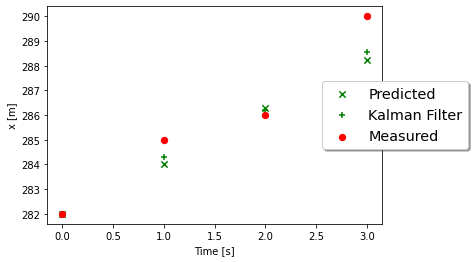

In [112]:

#Constants
plot_graph = True
dt = 1.0
x = 4000; x_dot = 280 
P_sd_x = 20; P_sd_x_dot = 5
R_sd_x = 25; R_sd_x_dot = 6

ekf = EKF(dt, x, x_dot, P_sd_x, P_sd_x_dot, R_sd_x, R_sd_x_dot)

#Controls 
# [x_dot_dot] 
U = 2

#Measurements
Y = np.array([  [4260, 282],
                [4550, 285],
                [4860, 286],
                [5110, 290]])

print(f"Starting conditions")
print(f"    x:{ekf.X[0]}")
print(f"      {ekf.X[1]}")
print(f"    P:{ekf.P[0,0]}, {ekf.P[0,1]}")
print(f"      {ekf.P[1,0]}, {ekf.P[1,1]}")

if (plot_graph):
    fig, ax = plt.subplots()

for i in range(0,4):
    print(f"Iteration {i+1}")

    X_pred, P = ekf.predictState(U)

    K = ekf.calcKalmanGain()

    ekf.inputMeasurement(Y[i,0], Y[i,1])

    X_updated = ekf.calcCurrentState()

    P_updated = ekf.updateProcessCovarianceMatrix()

    print(f"    X_pred: {X_pred[0]}")
    print(f"            {X_pred[1]}")

    # print(f"    Y:{Y[i,0]}")
    # print(f"      {Y[i,1]}")

    print(f"    P_predicted:{P[0,0]}, {P[0,1]}")
    print(f"                {P[1,0]}, {P[1,1]}")

    print(f"    K:{K[0,0]}, {K[0,1]}")
    print(f"      {K[1,0]}, {K[1,1]}")

    print(f"    X_updated:  {X_updated[0]}")
    print(f"                {X_updated[1]}")

    print(f"    P_updated:{P_updated[0,0]}, {P_updated[0,1]}")
    print(f"              {P_updated[1,0]}, {P_updated[1,1]}")

    if (plot_graph):
        ax.scatter(i, float(X_pred[0]), color='green', s=40, 
                    marker='x', label='Predicted')
        ax.scatter(i, float(X_updated[0]), color='green', s=40, 
                    marker='+', label='Kalman Filter')
        ax.scatter(i, float(Y[i,0]), color='red', s=40, 
                    marker='o', label='Measured')
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('x [m]')

        #Remove repeated labels
        handles, labels = ax.get_legend_handles_labels()
        handle_list, label_list = [], []
        for handle, label in zip(handles, labels):
            if label not in label_list:
                handle_list.append(handle)
                label_list.append(label)

        ax.legend(handle_list, label_list, loc='center left', 
                    shadow=True, fontsize='x-large', bbox_to_anchor=(0.8, 0.5))

        try:
            plt.plot()
            display.display(plt.gcf())
            display.clear_output(wait=True)
            time.sleep(0.1)
        except KeyboardInterrupt:
            break


# Prediction Step (2D)

$$ X_k = A \cdot X_{k-1} + B \cdot u_{k} + w_k $$

$$
X_k = 
\begin{bmatrix}
1 & 0 & \Delta T & 0 \\
0 & 1 & 0 & \Delta T \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 
\end{bmatrix}

\cdot 

\begin{bmatrix}
x_{k-1} \\
y_{k-1} \\
\dot{x}_{k-1} \\
\dot{y}_{k-1} 
\end{bmatrix}

+

\begin{bmatrix}
\dfrac{1}{2} \Delta T^2 & 0\\
0 & \dfrac{1}{2} \Delta T^2\\
\Delta T & 0\\
0 & \Delta T
\end{bmatrix}

\cdot 

\begin{bmatrix}
a_x \\
a_y 
\end{bmatrix}


+

0

$$

$$ 
x = 
\begin{bmatrix}
x \\
y \\
\dot{x} \\
\dot{y}
\end{bmatrix}
$$

$$ 
p = 
\begin{bmatrix}
x_{err}^2 & 0 & 0 & 0 \\
0 & y_{err}^2 & 0 & 0\\
0 & 0 & \dot{x}_{err}^2 & 0\\
0 & 0 & 0 & \dot{y}_{err}^2
\end{bmatrix}
$$
